In [1]:
# update for tensorflow
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import seaborn as sns
import random as rn
import re
import warnings
import csv

import tensorflow as tf
# Force TensorFlow to single thread
# Multiple threads are a potential source of non-reprocible research resulsts
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )

# tf.set_random_seed() will make random number generation in the TensorFlow backend
# have a well defined initial state
# more details: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.compat.v1.set_random_seed(515)

# keras / deep learning libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential # a sequence of neuronal layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense # layer representing a neuron
from tensorflow.keras.optimizers import Nadam # optimisation algorithm to find the best weights in the model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig
plt.style.use('seaborn-deep')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
sns.set()

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# mlp for the two circles classification problem
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.initializers import RandomUniform

In [2]:
# #############################################################################
# Plot results

def myplot(score,coeff, y, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [3]:
# breast data
breast_data = pd.read_csv("data/breast_data_full.csv")
breast_data = breast_data.drop(["id"], axis=1)
breast_data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


We have a total of 30 features.

You start by Standardizing the data since PCA's output is influenced based on the scale of the features of the data.

In [7]:
from sklearn.preprocessing import StandardScaler

features = breast_data.drop("diagnosis", axis=1).columns.tolist()
diagnosis = breast_data["diagnosis"]

X = breast_data.loc[:, features].values
X = StandardScaler().fit_transform(X) # normalizing the features

# putting scalled data into dataframe format
normalised_data = pd.DataFrame(X,columns=features)
normalised_data["diagnosis"] = diagnosis
normalised_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091,1
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978,1
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409,1
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635,1


In [8]:
np.mean(X),np.std(X)

(-6.826538293184326e-17, 1.0)

## PCA - Principal Component Analysis

When we have a dataset with a lot features, there usually are lots of features that are either redundant or noisy. For dimensionality reduction, it is important to identify these types of features, otherwise we might end up removing important information about our data.

**In other words, we should be removing features that will not impact the patterns in data or the prediction results**

Principal Component Analysis (PCA) is an unsupervised learning method that can help us reduce the dimensionlity of the space without impacting too much on the prediction results. PCA is especially important for a problem called *The Curse of Dimensionality* 

### The Curse of Dimensionality

The Curse of Dimensionality refers to various phenomena that arise when analysing and organising data in high-dimensional spaces, but does not occur in low-dimensional settings. Due to the curse of dimensionality, search algorithms suffer from an exponential decrease of performance as the dimension of the metric space increases. Here are two examples of the problem of the curse of dimensinality. 

<img src="./graphics/cd2.png" width="700" />

<img src="./graphics/cd1.png" width="700" />

### Correlation Analysis

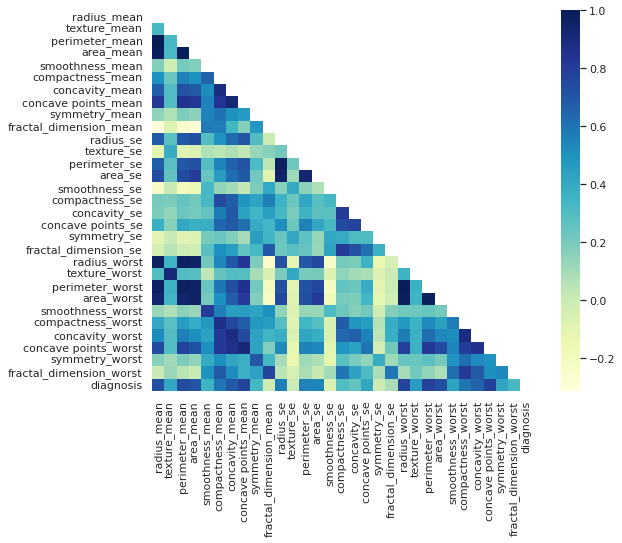

In [9]:
corr = normalised_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=1.0, square=True, cmap="YlGnBu")




Things to take into consideration when doing a correlation analysis:
- We prefer variables that are highly correlated with the class variable (in this case, with "diagnosis");
- We want to avoid input variables that are correlated with each other. This means that the variables share similar characteristics and for that reason are redundant. In this case, we should consider removing variables with a correlation higher than 0.6.



### A Method to Search for Important Features

In [10]:
from sklearn.ensemble import RandomForestRegressor
df = normalised_data.drop("diagnosis", axis=1)
model = RandomForestRegressor(random_state=1, max_depth=10)
df=pd.get_dummies(df)
model.fit(df, normalised_data["diagnosis"])

RandomForestRegressor(max_depth=10, random_state=1)

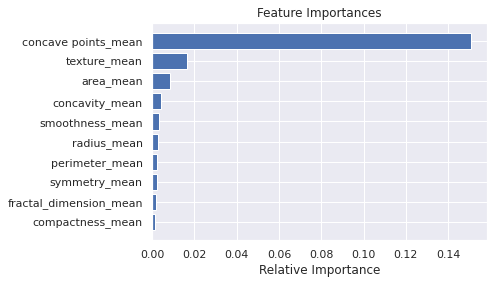

In [11]:
NUM_FEATURES = 10

features = normalised_data.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:NUM_FEATURES])  # top features

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Dimensionality Reduction with PCA

In [12]:
#from statsmodels.multivariate.pca import PCA
from sklearn.decomposition import PCA

pca = PCA( ) # you can specify a number of principal components using n_components
pca_result = pca.fit_transform( normalised_data.drop("diagnosis", axis=1)   )
pd.DataFrame(pca_result) # principle components

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,...,0.006888,-0.067000,0.088590,0.107898,0.219520,-0.122900,0.159198,0.009853,0.007119,-0.001415
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,...,-0.009802,0.019563,-0.055405,0.086135,0.001197,0.065889,-0.068512,-0.023575,-0.027486,-0.010419
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,...,-0.036592,0.063352,-0.200312,-0.044819,0.002429,0.007095,-0.023691,-0.002578,0.006706,0.003770
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,...,0.140648,-0.042478,0.168820,-0.195969,0.377830,-0.198192,-0.027409,-0.068086,-0.084163,-0.023783


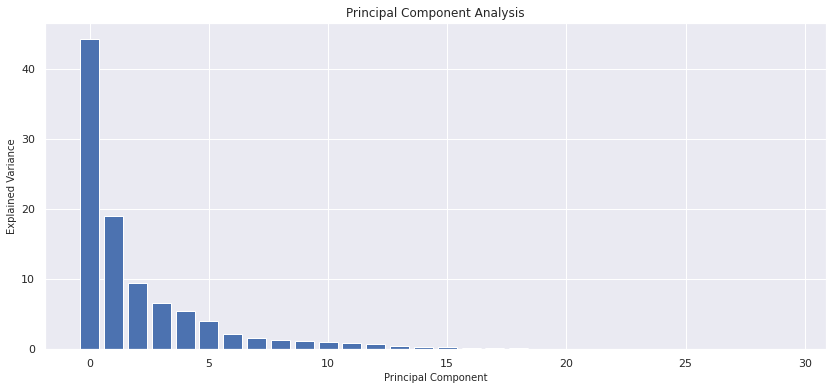

In [13]:
index = np.arange(len(pca.explained_variance_ratio_))
plt.figure(figsize=(14,6))
plt.title('Principal Component Analysis')
plt.bar(index, pca.explained_variance_ratio_*100)
plt.xlabel('Principal Component', fontsize=10)
plt.ylabel('Explained Variance', fontsize=10)
plt.show()

#### Method 1: Eigenvalues

In [14]:
# we look at the eigen values and we discard all the components with eigenvalues smaller than 1
# this is known as the Kaiser criterion. 

# in this Python library, the closest we get to the eigen values is the singular values
pca.singular_values_ 

array([86.93235745, 56.90677266, 40.04263937, 33.57058877, 30.62887007,
       26.2104161 , 19.60102663, 16.46800391, 15.4017255 , 14.12602481,
       12.93205441, 12.19019359, 11.71889139,  9.4519063 ,  7.31866075,
        6.74106325,  5.81360925,  5.47175363,  5.30591648,  4.21066503,
        4.12971871,  3.95133143,  3.72155031,  3.20519874,  2.96796958,
        2.15709923,  1.98150547,  0.95096438,  0.65273958,  0.27514088])

We can remove three features from this data according to Kaiser criterion. Maybe this is not enough, so let's look at another way.

#### Method 2: Explanation Variance

The explanation variance is a methd that allows you to pick the total amount of variance in the dataset you want principal components to encode. Usually these cut-off values are 80% or 90%.


In [15]:
# the cummulative variance can allow us to choose the components with the biggest variance
cummulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance_explained = pd.DataFrame(data=cummulative_var, columns=['cumulative_var'])
print(cumulative_variance_explained)

    cumulative_var
0         0.442720
1         0.632432
2         0.726364
3         0.792385
4         0.847343
5         0.887588
6         0.910095
7         0.925983
8         0.939879
9         0.951569
10        0.961366
11        0.970071
12        0.978117
13        0.983350
14        0.986488
15        0.989150
16        0.991130
17        0.992884
18        0.994533
19        0.995572
20        0.996571
21        0.997486
22        0.998297
23        0.998899
24        0.999415
25        0.999688
26        0.999918
27        0.999971
28        0.999996
29        1.000000


If we were to use this method, we have:
- The first four principal components explain a bit more than 80% of the variance,
- The first six principal components would roughly explain 90% of the variance in our dataset.

We can use the first four or first six principal components, depending on the cut-off that we established. For this tutorial, let's use the first four. One can see this clearer in the following visualisation

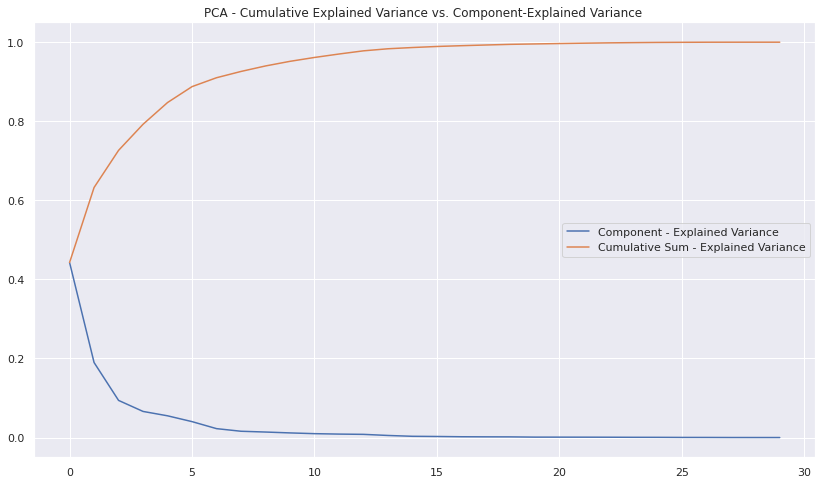

In [16]:
plt.figure(figsize=(14,8))
plt.plot(range(len(pca.components_)), pca.explained_variance_ratio_)
plt.plot(range(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA - Cumulative Explained Variance vs. Component-Explained Variance ")
plt.legend(("Component - Explained Variance","Cumulative Sum - Explained Variance"))

#### Finalising Analysis

We saw that 4 components are enough to express 80% of our data, so let's apply PCA for 4 compoenents

In [17]:
pca = PCA( n_components = 4 )  
pca_result = pca.fit_transform( normalised_data.drop("diagnosis", axis=1)   )
df_res = pd.DataFrame(pca_result, columns=["principal_component_1","principal_component_2","principal_component_3","principal_component_4"]) # principle components
df_res

,principal_component_1,principal_component_2,principal_component_3,principal_component_4
0,9.192837,1.948583,-1.123167,3.633732
1,2.387802,-3.768172,-0.529293,1.118264
2,5.733896,-1.075174,-0.551747,0.912082
3,7.122953,10.275589,-3.232790,0.152548
4,3.935302,-1.948072,1.389767,2.940639
...,...,...,...,...
564,6.439315,-3.576817,2.459488,1.177313
565,3.793382,-3.584048,2.088476,-2.506027
566,1.256179,-1.902297,0.562731,-2.089227
567,10.374794,1.672010,-1.877029,-2.356032


Remember in PCA we lose interpretability. By projecting the data into the component with the highest variance, you lose information and consequently interpretability.

In [18]:
# interpretability
import statsmodels.multivariate.pca as st

pca2 = st.PCA( normalised_data.drop("diagnosis", axis=1) , ncomp = 4, method='eig' )
loadings = pca2.loadings
loadings

,comp_0,comp_1,comp_2,comp_3
radius_mean,-0.218902,0.233857,0.008531,-0.041409
texture_mean,-0.103725,0.059706,-0.064550,0.603050
perimeter_mean,-0.227537,0.215181,0.009314,-0.041983
area_mean,-0.220995,0.231077,-0.028700,-0.053434
smoothness_mean,-0.142590,-0.186113,0.104292,-0.159383
compactness_mean,-0.239285,-0.151892,0.074092,-0.031795
concavity_mean,-0.258400,-0.060165,-0.002734,-0.019123
concave points_mean,-0.260854,0.034768,0.025564,-0.065336
symmetry_mean,-0.138167,-0.190349,0.040240,-0.067125
fractal_dimension_mean,-0.064363,-0.366575,0.022574,-0.048587


### PCA on the Web




<img src="./graphics/pca.png" width="700" />

URL here: <a href="https://setosa.io/ev/principal-component-analysis/">PCA example</a>